In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Fri Jun 24 00:45:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 28%   36C    P8    21W / 260W |   3450MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# LDA

## 2016 brief paragraph

In [3]:
file_us = open("../LDA/segment/data/us_file_brief_paragraph_2016.txt", "r")
us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(us_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(6701 unique tokens: ['apparatus', 'base', 'bs', 'case', 'communication']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in us_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-6.613964,745.431950
1,3,-6.595701,731.941877
2,4,-6.592850,729.858297
3,5,-6.584578,723.845686
4,6,-6.571999,714.797336
5,7,-6.557982,704.847796
6,8,-6.550794,699.799600
7,9,-6.551052,699.980131
8,10,-6.545384,696.023937
9,11,-6.547296,697.355773


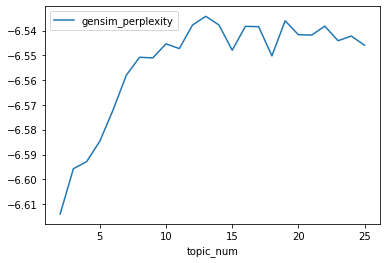

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-6.613964,745.431950
1,3,-6.595701,731.941877
2,4,-6.592850,729.858297
3,5,-6.584578,723.845686
4,6,-6.571999,714.797336
5,7,-6.557982,704.847796
6,8,-6.550794,699.799600
7,9,-6.551052,699.980131
8,10,-6.545384,696.023937
9,11,-6.547296,697.355773


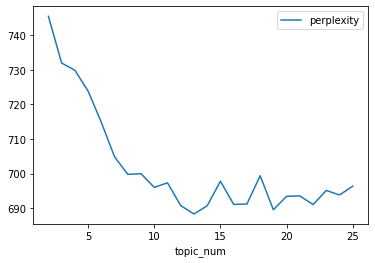

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_us_brief_paragraph_2016.csv", index=False)

## priority description sentence

In [11]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

11

In [23]:
topics_us = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_us.append(c.index(max(c)))

In [24]:
topics_us

[11,
 5,
 5,
 12,
 4,
 10,
 8,
 8,
 2,
 8,
 6,
 9,
 8,
 9,
 8,
 10,
 9,
 6,
 5,
 10,
 5,
 2,
 1,
 9,
 11,
 4,
 6,
 2,
 4,
 8,
 1,
 12,
 1,
 9,
 8,
 1,
 9,
 11,
 8,
 2,
 1,
 1,
 6,
 5,
 2,
 8,
 9,
 8,
 9,
 6,
 12,
 12,
 7,
 8,
 11,
 12,
 4,
 5,
 4,
 12,
 12,
 4,
 9,
 4,
 7,
 6,
 5,
 4,
 1,
 2,
 11,
 4,
 2,
 12,
 7,
 11,
 7,
 4,
 5,
 4,
 5,
 2,
 7,
 7,
 4,
 4,
 5,
 11,
 6,
 6,
 12,
 4,
 4,
 12,
 4,
 2,
 4,
 4,
 9,
 3,
 12,
 4,
 7,
 2,
 7,
 11,
 8,
 12,
 7,
 6,
 8,
 5,
 6,
 4,
 5,
 4,
 9,
 7,
 12,
 4,
 5,
 4,
 5,
 7,
 6,
 8,
 10,
 8,
 3,
 11,
 8,
 4,
 6,
 7,
 5,
 1,
 4,
 8,
 4,
 10,
 4,
 2,
 3,
 2,
 3,
 7,
 6,
 5,
 6,
 6,
 8,
 12,
 11,
 5,
 12,
 1,
 6,
 4,
 12,
 12,
 7,
 4,
 5,
 9,
 8,
 7,
 2,
 4,
 8,
 1,
 4,
 6,
 1,
 12,
 8,
 1,
 7,
 2,
 2,
 10,
 3,
 7,
 6,
 3,
 8,
 8,
 12,
 4,
 9,
 0,
 8,
 2,
 8,
 6,
 8,
 8,
 8,
 8,
 0,
 3,
 11,
 3,
 5,
 2,
 4,
 8,
 8,
 5,
 5,
 8,
 10,
 2,
 6,
 8,
 7,
 8,
 2,
 4,
 8,
 4,
 11,
 5,
 4,
 2,
 5,
 0,
 7,
 9,
 4,
 5,
 7,
 4,
 1,
 9,
 7,
 5,
 8,
 8,
 11,
 11,


In [25]:
print(len(topics_us))
print(len(us_desc))

3555
3555


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2016 = db.rm_patent_us_2016
    db_rm_us_2016 = db.rm_patent_us_2016
    # db_rm_de_2016 = db.rm_patent_de_2016
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_us_desc = db_rm_us_2016.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_us_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_us

,id,patentNumber,company,brief
0,62009bab7b73c16636b3108e,US10602420B2,[Samsung Electronics Co Ltd],An apparatus and method for providing handover...
1,62009c947b73c16636b310a4,US20160283621A1,[SAS Institute Inc],Possible outcomes can be determined by combini...
2,62009ce27b73c16636b310ae,US20160321316A1,[GDIAL Inc],The present specification provides a method co...
3,62009ce97b73c16636b310b0,US9665405B1,[SAS Institute Inc],Systems and methods are provided for generatin...
4,62009fee7b73c16636b310c2,US20170063566A1,[Electro Industries Gauge Technology],The present disclosure is directed to an intel...
...,...,...,...,...
3550,6208fa0ce0ec9a30af2ab36f,US20190128710A1,[],In a conventional sensor signal detection devi...
3551,6208fa30e0ec9a30af2ab381,US20170249288A1,[Fujitsu Ltd],An extensible markup language schema definitio...
3552,6208fa80e0ec9a30af2ab397,US20170230367A1,[Silent Circle SA],Techniques concerning the authentication of co...
3553,6208fb67e0ec9a30af2ab3df,US10044108B2,[Johns Hopkins University],Example apparatuses and methods relating to an...


In [30]:
print(len(df_us))
print(len(us_desc))

3555
3555


In [31]:
df_us["topic"]=topics_us

In [32]:
df_us

,id,patentNumber,company,brief,topic
0,62009bab7b73c16636b3108e,US10602420B2,[Samsung Electronics Co Ltd],An apparatus and method for providing handover...,11
1,62009c947b73c16636b310a4,US20160283621A1,[SAS Institute Inc],Possible outcomes can be determined by combini...,5
2,62009ce27b73c16636b310ae,US20160321316A1,[GDIAL Inc],The present specification provides a method co...,5
3,62009ce97b73c16636b310b0,US9665405B1,[SAS Institute Inc],Systems and methods are provided for generatin...,12
4,62009fee7b73c16636b310c2,US20170063566A1,[Electro Industries Gauge Technology],The present disclosure is directed to an intel...,4
...,...,...,...,...,...
3550,6208fa0ce0ec9a30af2ab36f,US20190128710A1,[],In a conventional sensor signal detection devi...,6
3551,6208fa30e0ec9a30af2ab381,US20170249288A1,[Fujitsu Ltd],An extensible markup language schema definitio...,10
3552,6208fa80e0ec9a30af2ab397,US20170230367A1,[Silent Circle SA],Techniques concerning the authentication of co...,6
3553,6208fb67e0ec9a30af2ab3df,US10044108B2,[Johns Hopkins University],Example apparatuses and methods relating to an...,8


In [33]:
df_us2 = df_us.explode('company')
df_us2

,id,patentNumber,company,brief,topic
0,62009bab7b73c16636b3108e,US10602420B2,Samsung Electronics Co Ltd,An apparatus and method for providing handover...,11
1,62009c947b73c16636b310a4,US20160283621A1,SAS Institute Inc,Possible outcomes can be determined by combini...,5
2,62009ce27b73c16636b310ae,US20160321316A1,GDIAL Inc,The present specification provides a method co...,5
3,62009ce97b73c16636b310b0,US9665405B1,SAS Institute Inc,Systems and methods are provided for generatin...,12
4,62009fee7b73c16636b310c2,US20170063566A1,Electro Industries Gauge Technology,The present disclosure is directed to an intel...,4
...,...,...,...,...,...
3550,6208fa0ce0ec9a30af2ab36f,US20190128710A1,NaN,In a conventional sensor signal detection devi...,6
3551,6208fa30e0ec9a30af2ab381,US20170249288A1,Fujitsu Ltd,An extensible markup language schema definitio...,10
3552,6208fa80e0ec9a30af2ab397,US20170230367A1,Silent Circle SA,Techniques concerning the authentication of co...,6
3553,6208fb67e0ec9a30af2ab3df,US10044108B2,Johns Hopkins University,Example apparatuses and methods relating to an...,8


In [34]:
# 排名前16的公司
c_ls = list(df_us2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Samsung Electronics Co Ltd',
 'Intel Corp',
 'Qualcomm Inc',
 'Telefonaktiebolaget LM Ericsson AB',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Sony Corp',
 'NEC Corp',
 'Electronics and Telecommunications Research Institute ETRI',
 'NTT Docomo Inc',
 'Convida Wireless LLC',
 'Amazon Technologies Inc',
 'Nokia Technologies Oy',
 'General Electric Co']

### 轉成company-topic 的總數表格

In [35]:
df_us_count = df_us2.groupby(["company","topic"],as_index=False).size()
df_us_count

,company,topic,size
0,12a Systems Co Ltd,6,1
1,7Signal Inc,2,1
2,ACCUSONUS Inc,8,1
3,APPSFREEDOM Inc,5,1
4,ARAM SOLUTION Co Ltd,3,1
...,...,...,...
1444,Zeroin Precision Systems LLC,7,1
1445,Ziften Technologies Inc,3,1
1446,Zuul Inc,7,1
1447,comScore Inc,7,1


In [36]:
# 轉成company-topic 的總數表格
table_us = df_us_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_us = table_us.droplevel(level=0, axis=1)
table_us = table_us.rename(columns={'':'company'})

In [37]:
table_us

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12
0,12a Systems Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7Signal Inc,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ACCUSONUS Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,APPSFREEDOM Inc,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ARAM SOLUTION Co Ltd,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,Zeroin Precision Systems LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
786,Ziften Technologies Inc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,Zuul Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
788,comScore Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
final_table_us = table_us[table_us.company.isin(c_ls)]
final_table_us

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12
44,Amazon Technologies Inc,1.0,1.0,2.0,4.0,2.0,2.0,0.0,10.0,0.0,3.0,0.0,0.0,4.0
131,Cisco Technology Inc,0.0,2.0,13.0,0.0,21.0,3.0,0.0,34.0,3.0,6.0,2.0,0.0,4.0
149,Convida Wireless LLC,1.0,2.0,6.0,1.0,1.0,1.0,0.0,0.0,0.0,7.0,2.0,4.0,6.0
195,Electronics and Telecommunications Research In...,0.0,2.0,6.0,2.0,0.0,8.0,2.0,2.0,4.0,2.0,0.0,3.0,4.0
251,General Electric Co,0.0,0.0,1.0,5.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,11.0
334,Intel Corp,9.0,11.0,34.0,14.0,45.0,13.0,29.0,19.0,39.0,28.0,9.0,11.0,12.0
343,International Business Machines Corp,1.0,6.0,6.0,2.0,14.0,10.0,9.0,11.0,2.0,10.0,4.0,3.0,11.0
386,LG Electronics Inc,1.0,49.0,17.0,5.0,1.0,1.0,2.0,3.0,0.0,3.0,3.0,5.0,2.0
437,Microsoft Technology Licensing LLC,1.0,2.0,7.0,3.0,3.0,4.0,3.0,9.0,4.0,2.0,2.0,3.0,13.0
449,NEC Corp,0.0,6.0,6.0,0.0,2.0,4.0,5.0,3.0,4.0,1.0,3.0,0.0,3.0


In [39]:
final_table_us.shape

(16, 14)

In [40]:
table_us.to_csv('company_lda_brief_us_2016.csv',index=0)